### 1. Data downloading and exploration

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snssa

In [2]:
dataset = load_dataset("banking77")

train = dataset["train"]
test = dataset["test"]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 10003
Test size: 3080


In [3]:
df_train = train.to_pandas()
df_test = test.to_pandas()

df_train.head()

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


#### 1.1. Data exploration - dtypes, dataset size, classes range etc.

In [4]:
print("Train info:")
print(df_train.info())

print("\nTest info:")
print(df_test.info())

print("\nSample labels:", df_train["label"].unique()[:10])
print("Min label:", df_train["label"].min())
print("Max label:", df_train["label"].max())

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10003 non-null  object
 1   label   10003 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None

Test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3080 non-null   object
 1   label   3080 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.3+ KB
None

Sample labels: [11 13 32 17 34 46 36 12  4 14]
Min label: 0
Max label: 76


#### 1.2. Text lengths histogram

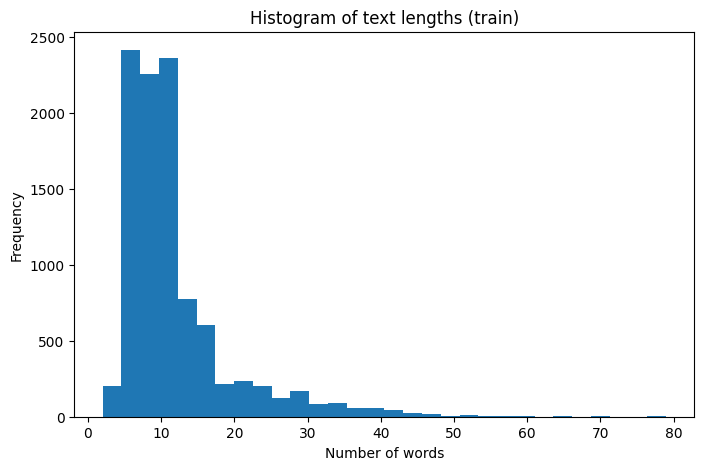

In [5]:
train_lengths = df_train["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(train_lengths, bins=30)
plt.title("Histogram of text lengths (train)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

#### 1.3. Class distribution

/tmp/ipykernel_9208/1574729949.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train["label"], palette="viridis")


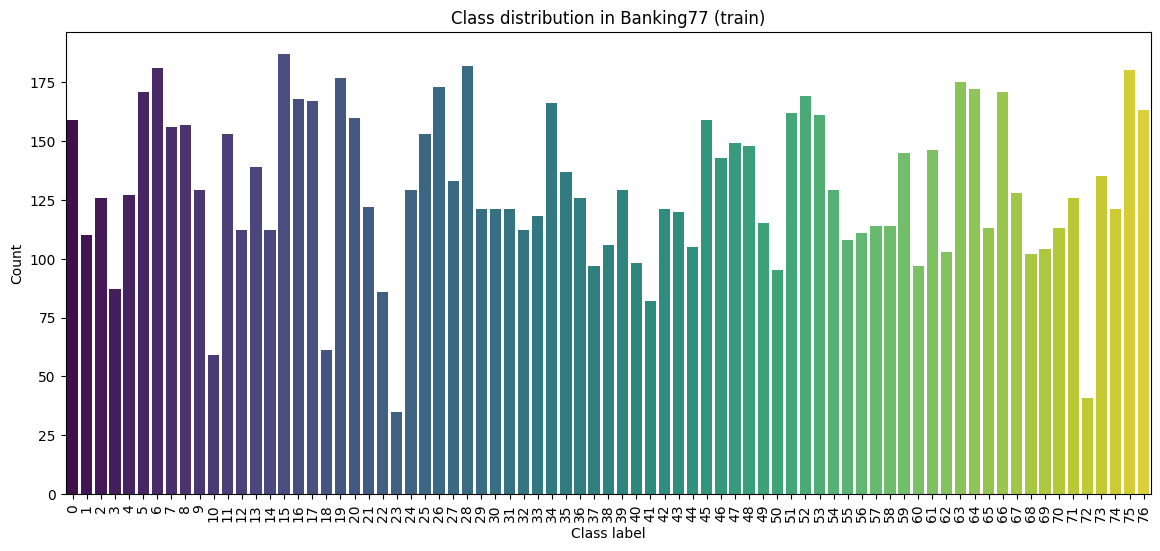

In [6]:
plt.figure(figsize=(14,6))
sns.countplot(x=df_train["label"], palette="viridis")
plt.title("Class distribution in Banking77 (train)")
plt.xlabel("Class label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [7]:
print("Average text length:", train_lengths.mean())
print("Median text length:", train_lengths.median())
print("Max length:", train_lengths.max())
print("Min length:", train_lengths.min())

Average text length: 11.949415175447365
Median text length: 10.0
Max length: 79
Min length: 2


### 2. Cleaning data w. Cleanlab

#### 2.1. Model training and embedding

In [8]:
import numpy as np
from sentence_transformers import SentenceTransformer

texts_train = df_train["text"].to_numpy()
labels_train = df_train["label"].to_numpy()

embedder = SentenceTransformer("all-MiniLM-L6-v2")

emb_train = embedder.encode(texts_train, show_progress_bar=True, batch_size=64)
emb_train = np.asarray(emb_train)
emb_train.shape

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

(10003, 384)

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_predict

clf = LogisticRegressionCV(
    Cs=10,
    cv=5,
    max_iter=2000,
    multi_class="auto",
    class_weight="balanced",
    n_jobs=-1,
)

pred_probs = cross_val_predict(
    clf,
    emb_train,
    labels_train,
    cv=5,
    method="predict_proba",
    n_jobs=-1,
)
pred_probs.shape


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

(10003, 77)

#### 2.2. Running DataLab

In [24]:
from cleanlab import Datalab

data_dict = {
    "text": texts_train,
    "label": labels_train,
}

lab = Datalab(data_dict, label_name="label", task="classification")
lab.find_issues(pred_probs=pred_probs, features=emb_train)
issues = lab.get_issues()
lab.report()

Finding null issues ...
Finding label issues ...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 633 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         151
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
    to the rest of the dataset.  The examples flagg

#### 2.3. Duplicates

In [26]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

for idx, row in duplicate_issues.head(10).iterrows():
    text = texts_train[idx]
    neighbors = texts_train[row["near_duplicate_sets"][:3]]
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print(f"Idxes: {idx}, Near duplicate idxes: {row['near_duplicate_sets'][:3]}")
    print()

Text: 
I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
	Duplicates: ['I put the wrong pin too many times and now it is blocked. Can you help me unblock it?']
Idxes: 1710, Near duplicate idxes: [1724]

Text: 
I can't seem to be able to use my card



	Duplicates: ["I can't seem to be able to use my card"]
Idxes: 1290, Near duplicate idxes: [1246]

Text: I can't seem to be able to use my card
	Duplicates: ["\nI can't seem to be able to use my card\n\n\n"]
Idxes: 1246, Near duplicate idxes: [1290]

Text: Where can I withdraw money from?
	Duplicates: ['\nWhere can I withdraw money from?']
Idxes: 4594, Near duplicate idxes: [4595]

Text: 
Where can I withdraw money from?
	Duplicates: ['Where can I withdraw money from?']
Idxes: 4595, Near duplicate idxes: [4594]

Text: How can I reset my passcode?
	Duplicates: ['How can i reset my passcode ?' 'How do I reset my passcode?']
Idxes: 4903, Near duplicate idxes: [4915 4839]

Text: How can i reset my passcode 

In [28]:
df_train["text_lower"] = df_train["text"].str.lower()
df_deduplicated = df_train.drop_duplicates(subset="text_lower")
df_deduplicated = df_deduplicated.drop(columns="text_lower")
df_deduplicated = df_deduplicated.reset_index(drop=True)
df_deduplicated

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24


#### 2.4. Label Issues

In [29]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

top_label_issues_y_true = label_issues.head(10)["given_label"]
top_label_issues_y_pred = label_issues.head(10)["predicted_label"]
top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts_train[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(top_label_issues_texts, top_label_issues_y_true, top_label_issues_y_pred):
    print(f"y_true {y_true}, y_pred {y_pred}, text: {text}")
    print()


Top 10 label issues
y_true 11, y_pred 14, text: WHAT IS THE SOLUTION OF THIS PROBLEM

y_true 29, y_pred 40, text: i am not a premium customer but i want a virtual card, how do i get it

y_true 41, y_pred 11, text: Can you tell me the status of my new card?

y_true 27, y_pred 7, text: please help me with this transfer, for some reason i can't transfer to a cryptocurency account

y_true 14, y_pred 49, text: Can I use app to reset PIN attempts?

y_true 49, y_pred 38, text: Where do I find PIN for my card?

y_true 47, y_pred 62, text: i put money on my card and i dont see it on the balance

y_true 26, y_pred 14, text: Is my card actually working? It's the first time I tried using it

y_true 65, y_pred 54, text: What currencies can I use to top up my account?

y_true 5, y_pred 48, text: My transfer is pending too long.



In [30]:
# make sure we don't get key errors - we removed some rows earlier during deduplication
label_issues = label_issues[label_issues.index.isin(df_deduplicated.index)]

idxs = label_issues.index.tolist()
pred_labels = label_issues["predicted_label"]

df_fixed = df_deduplicated.copy()
df_fixed.loc[idxs, "label"] = pred_labels
df_fixed

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24


#### 2.5. Outliers

In [32]:
outliers = lab.get_issues("outlier")
outliers = outliers[outliers["is_outlier_issue"]]
outliers = outliers.sort_values(by="outlier_score")

print("Top 10 outlier issues")
for idx, row in outliers.head(10).iterrows():
    text = texts_train[idx]
    score = row["outlier_score"]
    print(f"Outlier score: {score:.4f}, text: {text}")

Top 10 outlier issues
Outlier score: 0.0051, text: WHAT IS THE ATMOSPHERE OF IT
Outlier score: 0.0063, text: what is the word?
Outlier score: 0.0079, text: What is this witdrawal
Outlier score: 0.0079, text: what is the matter?
Outlier score: 0.0087, text: WHAT IS THE SOLUTION OF THIS PROBLEM
Outlier score: 0.0107, text: I prefer Mastecard.
Outlier score: 0.0164, text: I have made 5 attempts to make a very standard survey, yet I can't get it to work. What is the problem? Is there an issue related to your system?
Outlier score: 0.0167, text: WHAT IS THE MAIN REASON OF THIS PROBLEM
Outlier score: 0.0168, text: WHAT IS THE REASON FOR THAT
Outlier score: 0.0189, text: why was i chargged


In [34]:
#removing outliers
outlier_idxs = outliers.index.tolist()
df_final = df_fixed.drop(index=outlier_idxs)
df_final = df_final.reset_index(drop=True)
df_final

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9867,I just moved to the US how do I get a card?,24
9868,You provide support in what countries?,24
9869,What countries are you supporting?,24
9870,What countries are getting support?,24


#### 2.6. Discussion

### 3. Classifier

#### 3.1. Train test split

In [35]:
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

valid_size = 0.2
df_train_final, df_valid = train_test_split(df_final, test_size=valid_size, random_state=0, stratify=df_final["label"])

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train_final, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")
datasets_dict["test"] = Dataset.from_pandas(df_test, split="test")

In [37]:
from transformers import AutoTokenizer
import joblib

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


num_cores = joblib.cpu_count(only_physical_cores=True)
datasets_tokenized = datasets_dict.map(tokenize, batched=True)

Map:   0%|          | 0/7897 [00:00<?, ? examples/s]

Map:   0%|          | 0/1975 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [53]:
import os
import random

from sklearn.metrics import matthews_corrcoef
from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, EvalPrediction, Trainer, TrainingArguments
from sklearn.metrics import f1_score

# set determinism settings
os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=77)


# freeze some weights to speed up training
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

for param in model.distilbert.transformer.parameters():
    param.requires_grad = False


def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()
    logits = torch.from_numpy(eval_pred.predictions)
    # y_pred_proba = np.argmax(softmax(logits, dim=1).numpy(), axis=1)
    y_pred = torch.argmax(logits, dim=1).numpy()

    f1 = f1_score(y_true, y_pred, average="macro")
    mcc = matthews_corrcoef(y_true, y_pred)

    return {
        "f1_macro": f1,
        "mcc": mcc,
    }

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
training_args = TrainingArguments(
    output_dir="finetuned_hw_model",
    # change num_train_epochs depending on your hardware
    # if lower, increase learning rate and decrease save_steps and eval_steps
    learning_rate=1e-4,
    num_train_epochs=5,
    eval_strategy="steps",
    metric_for_best_model="f1_macro",
    save_steps=50,
    eval_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    seed=0,
    data_seed=0,
    fp16=True,  # comment this out if you have unsupported hardware
    dataloader_num_workers=1,  # comment out if necessary
)

In [60]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,F1 Macro,Mcc
50,No log,4.329951,0.000465,0.000000
100,No log,4.328763,0.000465,0.000000
150,No log,4.328673,0.000465,0.000000
200,No log,4.327969,0.000465,0.000000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

KeyboardInterrupt: 

In [22]:
import torch
from torch.nn.functional import softmax

pred_output = trainer.predict(valid_tokenized)
logits = torch.from_numpy(pred_output.predictions)

y_pred_proba = softmax(logits, dim=1).numpy()            # (n_samples, 77)
y_pred = np.argmax(y_pred_proba, axis=1)                 # (n_samples,)
y_true = np.array(valid_df["label"])

In [23]:
final_f1 = f1_score(y_true, y_pred, average="macro")
final_f1

0.9274878654477069